In [1]:
import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
from os import getcwd
from os import listdir
import cv2
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image  as mpimg
import shutil

from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,Dropout
from keras.layers import Conv2D,MaxPooling2D
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [2]:
data_path='/content/drive/My Drive/Faces_Data'
categories=os.listdir(data_path)
labels = [i for i in range(len(categories))]
label_dict=dict(zip(categories,labels)) #empty dictionary

print(labels)
print(categories)
print(label_dict)

[0, 1]
['Mask', 'No_Mask']
{'Mask': 0, 'No_Mask': 1}


In [3]:
img_size=100
data=[]
target=[]


for category in categories:
    folder_path=os.path.join(data_path,category)
    img_names=os.listdir(folder_path)
        
    for img_name in img_names:
        img_path=os.path.join(folder_path,img_name)
        img=cv2.imread(img_path)

        try:
            img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)           
            resized=cv2.resize(img,(img_size,img_size))
            #resizing the gray scale, since we need a fixed common size for all the images in the dataset
            data.append(resized)
            target.append(label_dict[category])
            #appending the image and the label(categorized) into the list (dataset)

        except Exception as e:
            print('Exception:',e)
            #if any exception rasied, the exception will be printed here. And pass to the next image

In [4]:
data=np.array(data)/255.0
data=np.reshape(data,(data.shape[0],img_size,img_size,3))
target=np.array(target)

new_target=np_utils.to_categorical(target)

## Convolutional Neural Network Architecture


*   Build the model
*   Compile the model
*   Train / fit the data to the model
*   Valuate the model on the testing set
*   Carry out an error analysis of our model



In [5]:
model=Sequential()

#First CNN layer by model followed by Relu and MaxPooling layers
model.add(Conv2D(200,(3,3),input_shape=(100, 100, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

#Now, second convolution layer followed by Relu and MaxPooling layers
model.add(Conv2D(100,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

#Flatten layer to stack the output convolutions from second convolution layer
model.add(Flatten())
model.add(Dropout(0.5))

#Dense layer of 64 neurons
model.add(Dense(64,activation='relu'))

#The Final layer with two outputs for two categories
model.add(Dense(2,activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [6]:
train_data,test_data,train_target,test_target=train_test_split(data,target,test_size=0.2)

Text(0.5, 1.0, 'Proportion of each observed category')

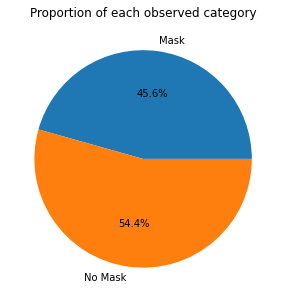

In [7]:
plt.figure(figsize=(10,5))
pie = [len(os.listdir(data_path + '/Mask')),len(os.listdir(data_path + '/No_Mask'))]
plt.pie(pie,
        labels = ['Mask','No Mask'],
        autopct='%1.1f%%'       
       )
plt.title('Proportion of each observed category')

In [8]:
# function for display 25 images from images array with its corresponding labels
def display_examples(class_names, images, labels):
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some 25 images of dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

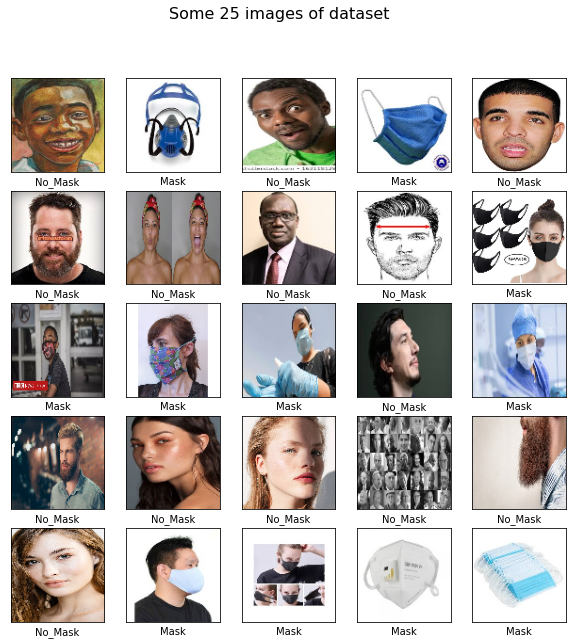

In [9]:
display_examples(categories,test_data,test_target)

In [10]:
checkpoint = ModelCheckpoint('model-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')
history=model.fit(train_data,train_target,epochs=20,callbacks=[checkpoint],validation_split=0.2)

Train on 636 samples, validate on 160 samples
Epoch 1/20
636/636 [==============================] - 52s 81ms/step - loss: 0.9663 - accuracy: 0.5802 - val_loss: 0.5952 - val_accuracy: 0.7312
Epoch 2/20
636/636 [==============================] - 51s 80ms/step - loss: 0.6090 - accuracy: 0.6792 - val_loss: 0.5177 - val_accuracy: 0.7625
Epoch 3/20
636/636 [==============================] - 51s 80ms/step - loss: 0.4660 - accuracy: 0.7909 - val_loss: 0.4681 - val_accuracy: 0.7812
Epoch 4/20
636/636 [==============================] - 51s 81ms/step - loss: 0.4280 - accuracy: 0.8129 - val_loss: 0.4382 - val_accuracy: 0.8062
Epoch 5/20
636/636 [==============================] - 51s 80ms/step - loss: 0.4144 - accuracy: 0.8255 - val_loss: 0.4516 - val_accuracy: 0.7750
Epoch 6/20
636/636 [==============================] - 51s 81ms/step - loss: 0.3681 - accuracy: 0.8506 - val_loss: 0.4407 - val_accuracy: 0.8062
Epoch 7/20
636/636 [==============================] - 51s 80ms/step - loss: 0.3844 - accur

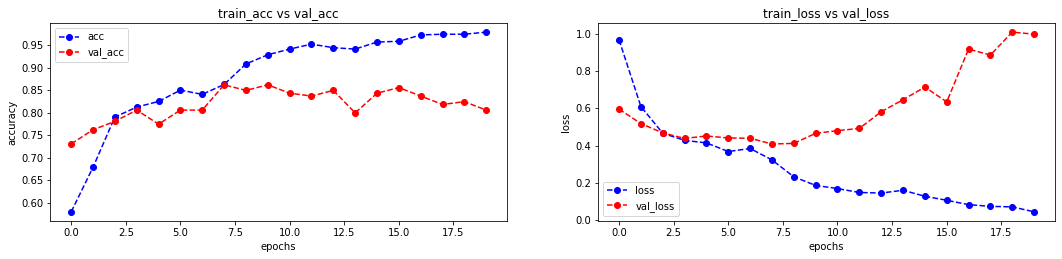

In [11]:
#draw accuracy and loss during the training of the network

def plot_accuracy_and_loss(history):
    fig = plt.figure(figsize=(18,8))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss 
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()
plot_accuracy_and_loss(history)

In [12]:
predictions = model.predict(test_data)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

Testing model on a random image from dataset

In [13]:
# check random image from the images array and its correspond label from the labels array.
def display_random_image(class_names, images, labels):
    
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

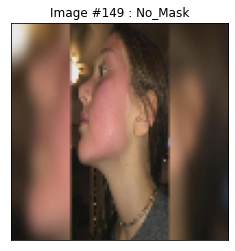

In [14]:
display_random_image(categories, test_data, test_target)

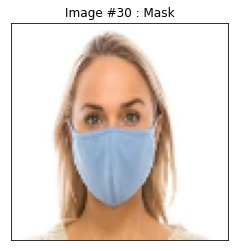

In [15]:
display_random_image(categories, test_data, test_target)

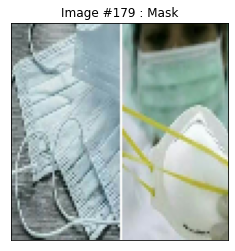

In [16]:
display_random_image(categories, test_data, test_target)

The accuracy value is normal, but the value of the error on validation is growing, let's look at examples where the neural network made a mistake


In [17]:
def print_mislabeled_images(class_names, test_images, test_labels, pred_labels):
    i = (test_labels == pred_labels)
    mislabeled_indices = np.where(i == 0)
    mislabeled_images = test_images[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]

    title = "Some examples of mislabeled images by the classifier:"
    display_examples(class_names,  mislabeled_images, mislabeled_labels)

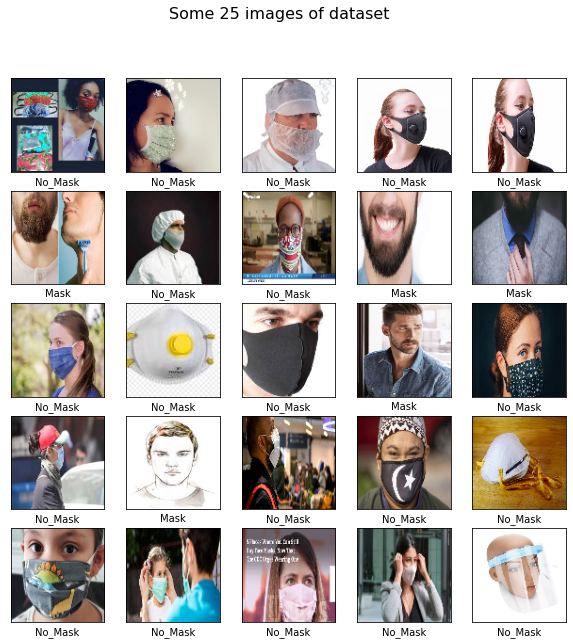

In [19]:
print_mislabeled_images(categories, test_data, test_target, pred_labels)

We see that the neural network can take a beard for a mask and does a poor job with unusual masks. This can be solved by data augmentation. Also, the dataset itself requires analysis and refinement
